In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import yfinance as yf

from mlfinlab.labeling.matrix_flags import MatrixFlagLabels

# Labeling: Matrix Flags


## Abstract 

The matrix flag labeling method is a multistep labeling method meant to match a data window of price data for a single stock with a template. In the literature, the template presented is a bull flag 10 by 10 template, with the first 7 columns representing the consolidation following an initial price surge, and the final 3 represent the breakout. Each column of the template corresponds to a chronological tenth of the data, and each row corresponds to a decile relative to the entire data window. Each element contains the proportion of points in each tenth that corresponds to the appropriate decile given by row. Once the data has been transformed this way, it is multiplied element-wise with the template, and the resulting matrix's sum of sum of columns is the scalar value denoting total fit for the day. The higher the fit, the better match with the template pattern.

## Introduction 

Labeling price data according to a template to identify patterns in price changes is featured in the following paper:
["Stock market trading rule based on pattern recognition and technical analysis: Forecasting the DJIA index with intraday data."](https://www.sciencedirect.com/science/article/abs/pii/S0957417415002110), by Cervelló-Royo et al., 2015.

This method was originally introduced in [Stock market trading rule discovery
using technical charting heuristics.](http://chart-patterns.technicalanalysis.org.uk/LMPR02.pdf), by Leigh et al., 2002, which describes this method in more detail.

A bull flag occurs when a stock's price rapidly increases, followed by a downwards trending consolidation period, followed by a breakout increase in price legitimizing and increasing on the original increase. As defined, "A bull flag pattern is a horizontal or downward sloping flag of consolidation followed by a sharp rise in the positive direction, the breakout." [Leigh et al. 2002]. Being able to identify the early stages of the breakout process can lead to a profitable strategy of buying the breakout and then selling some number of days later, when the price has theoretically stabilized again.

Cervelló-Royo et al. expand on Leigh et al.'s work by proposing a new bull flag pattern which ameliorates some weaknesses in Leigh's original template, such as the possibility of false positives given the path the stock took. Additionally, he applies this bull flag labeling method to intraday candlestick data, rather than just closing prices.

## How it works

The bull flag labeling pattern requires the use of a template to match the price data to. Below is an example bull flag
template originally used by Leigh et al. in 2002, and mentioned by Cervelló-Royo et al.

![image_example](img/bull_flag_template.png)
_*Fig. 1:*_ Original bull flag template. First 7 columns represend the consolidation while the last 3 represent breakout.

To find the template fitting value for a given day, the relevant data window consists of the day's price and prices of a number of preceding days. The data window is split into 10 buckets each containing a chronological tenth of
the data window. Decile cutoffs for prices in the entire data window are found. Each bucket is translated to a column with 10 elements, such that the topmost element is the proportions of prices in the bucket that is in the top decile in the entire data window, the second element is the proportion in the second decile, and so on until the tenth element is the proportion in the bottom decile. Thus, a column is generated for each of 10 buckets of the data. The columns are then put together chronologically such that the first column is on the left and last column is on the right in the resulting 10 by 10 matrix. The matrix is then multiplied element-wise by the template matrix, and all columns are summed. The sum of all columns, finally, is the fit value for the day. If desired, the user can specify a threshold to determine positive and negative classes. The value of the threshold depends on how strict of a classifier the user desires, and the allowable values based on the template matrix.

WE illustrate this with a simple example. Suppose we have the following data window of 20 prices \[100, 102, ..., 118, 120, 118, ..., 104, 102\]. The decile cutoffs are then \[102, 104, ..., 120\]. Note that these cutoffs are right inclusive, so a value of 102 would fit into the (100, 102) percentile. We split the data into ten chronological subsets such that the first subset is \[100, 102\]. 100% of elements in the first subset fall into the lowest decile, so the corresponding column would be \[0, 0, 0, 0, 0, 0, 0, 0, 0, 1\]. The second subset is \[104, 106\], of which 1 out of 2 is in the 2nd decile, and the other is in the 3rd decile, so the column would be \[0, 0, 0, 0, 0, 0, 0, 0.5, 0.5, 0\]. This is done until the entire 10 by 10 matrix is generated. This matrix is then multiplied element-wise by the template, and resulting values are summed to get the total template fit. The higher the fit, the better match to the template. Using the template shown above, the highest possible fit is 10.

---
## Examples of use

In [2]:
# Load price data. This method works on price data for a single stock, so a pd.Series must be used.
msft = yf.Ticker('SPY')
msft_df = msft.history(start='2019-1-1', end ='2020-5-18')

close = msft_df['Close']
close.head()

Date
2019-01-02    243.03
2019-01-03    237.23
2019-01-04    245.17
2019-01-07    247.11
2019-01-08    249.43
Name: Close, dtype: float64

Visualizing the data.

Text(0.5, 0, 'Date')

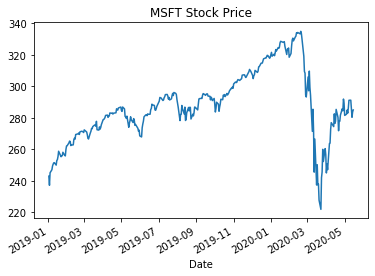

In [3]:
fig, ax = plt.subplots()
ax = plt.plot(close)
fig.autofmt_xdate()
plt.title('MSFT Stock Price')
plt.xlabel('Date')

## Getting scores

In [4]:
# We will use a window of 40.
window1 = 40
Flags = MatrixFlagLabels(data=close, window=window1)
Flags.apply_labeling_matrix()

Date
2019-03-01   -2.375
2019-03-04   -2.000
2019-03-05   -2.375
2019-03-06   -2.375
2019-03-07   -2.500
              ...  
2020-05-11   -2.750
2020-05-12   -2.500
2020-05-13   -2.500
2020-05-14   -2.250
2020-05-15   -2.750
Length: 306, dtype: float64

The higher the fit value for the day, the better the prices in the window preceding match the bull flag template. For categorical labels, we can use a threshold. Daily fits above the threshold will return a positive label.

In [5]:
# Use threshold of 3.
categorical = Flags.apply_labeling_matrix(threshold=3)
categorical.value_counts()

-1    271
 1     35
dtype: int64

## Impact of window size

We can visualize the points which get identified as being part of a bull flag pattern. The positive class marked on the figure match visually what a bull flag can look like. However, it's important to use the appropriate window relative to the timescale of price movements in the underlying; using too large or small of a window may result in missed labels.

Text(0.5, 1.0, 'Window = 40 days')

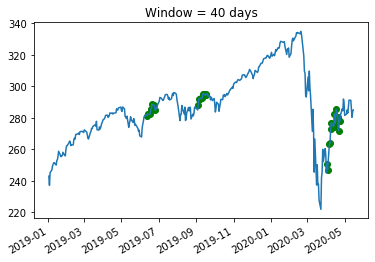

In [6]:
positives = close[window1:][categorical==1]

fig, ax = plt.subplots()
ax = plt.plot(close)
plt.scatter(positives.index, positives, color='g')
fig.autofmt_xdate()
plt.title('Window = 40 days')

Here are similar visualizations for varying window sizes.

Text(0.5, 1.0, 'Window = 10 days')

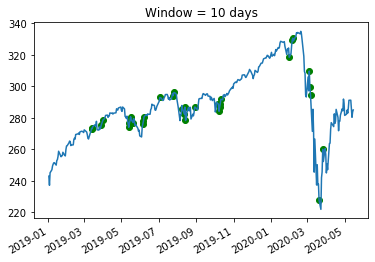

In [7]:
Flags2 = MatrixFlagLabels(data=close, window=10)
categorical2 = Flags2.apply_labeling_matrix(threshold=3)
positives2 = close[10:][categorical2==1]
fig, ax = plt.subplots()
ax = plt.plot(close)
plt.scatter(positives2.index, positives2, color='g')
fig.autofmt_xdate()
plt.title('Window = 10 days')

Text(0.5, 1.0, 'Window = 80 days')

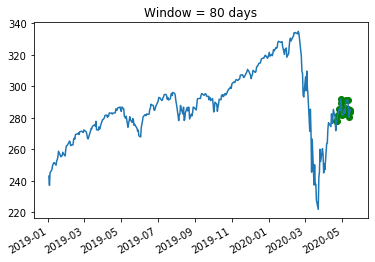

In [8]:
Flags3 = MatrixFlagLabels(data=close, window=80)
categorical3 = Flags3.apply_labeling_matrix(threshold=3)
positives3 = close[80:][categorical3==1]
fig, ax = plt.subplots()
ax = plt.plot(close)
plt.scatter(positives3.index, positives3, color='g')
fig.autofmt_xdate()
plt.title('Window = 80 days')

As we can see, having a shorter window results in identifying short term, more granular bull flags, while missing longer term trends. Having a longer window identifies longer term bull trends, but misses shorter term prices movements.

## Setting custom template

The default template is the one used by Leigh et al. However, there are some weaknesses with that template, in that false positives are possible depending on the path of prices \[Cervello-Royo et al., 2015\]. Referring to the template above, is is possible to trace the +1 values through the first 8 columns, and then rather than breaking out, trace the 0, and -2 values in the final 2 columns. This results in a very high fit value of 6, which should indicate a strong bull flag, but this is clearly a false positive. Cervelló-Royo et al. propose another template, which would ameliorate this problem. This template is likely only appropriate for intraday data, as it is too strict, with only 1 positive cell, to be used on close prices, which would demonstrate more local randomness.

In [9]:
# Cervelló-Royo's template
new_template = pd.DataFrame([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, -1, -1, -1, -1, -1, -1],
                            [0, 0, 0, -1, -2, -2, -2, -2, -2, -2],
                            [0, 0, -1, -3, -3, -3, -3, -3, -3, -3],
                            [0, -1, -3, -5, -5, -5, -5, -5, -5, -5],
                            [0, -1, -5, -5, -5, -5, -5, -5, -5, -5],
                            [0, -1, -5, -5, -5, -5, -5, -5, -5, -5],
                            [5, -1, -5, -5, -5, -5, -5, -5, -5, -5]])

In [10]:
Flags4 = MatrixFlagLabels(data=close, window=30)
Flags4.set_template(new_template)
Flags4.template

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,-1,-1,-1,-1,-1,-1
4,0,0,0,-1,-2,-2,-2,-2,-2,-2
5,0,0,-1,-3,-3,-3,-3,-3,-3,-3
6,0,-1,-3,-5,-5,-5,-5,-5,-5,-5
7,0,-1,-5,-5,-5,-5,-5,-5,-5,-5
8,0,-1,-5,-5,-5,-5,-5,-5,-5,-5
9,5,-1,-5,-5,-5,-5,-5,-5,-5,-5


## Bear instead of bull flags

Let's stick to the original template, but flip it horizontally to create the bear flag template instead.

In [11]:
window5=40
Flags5 = MatrixFlagLabels(data=close, window=window5)
bear_template = pd.DataFrame(np.flip(np.array(Flags5.template), axis=0))
Flags5.set_template(bear_template)
Flags5.template

,0,1,2,3,4,5,6,7,8,9
0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.5,0.5,-2.0,-2.5
1,-1.0,-1.0,-1.0,-0.5,0.0,0.5,1.0,1.0,0.0,-2.0
2,-0.5,-1.0,0.0,0.0,0.5,1.0,1.0,1.0,1.0,0.0
3,-0.5,0.0,0.0,0.5,1.0,1.0,0.5,0.5,1.0,1.0
4,0.0,0.0,0.5,1.0,1.0,0.5,0.0,0.0,1.0,1.0
5,0.0,0.5,1.0,1.0,0.5,0.0,0.0,0.0,0.5,1.0
6,0.5,1.0,1.0,0.5,0.0,-0.5,-0.5,-0.5,0.0,1.0
7,1.0,1.0,0.5,0.0,-0.5,-0.5,-0.5,-0.5,0.0,0.5
8,1.0,0.5,0.0,-0.5,-1.0,-1.0,-1.0,-1.0,-0.5,0.0
9,0.5,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0


Text(0.5, 1.0, 'Window = 40 days, Bear flags')

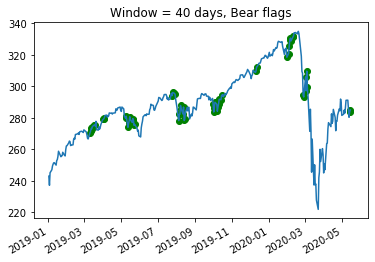

In [12]:
categorical5 = Flags5.apply_labeling_matrix(threshold=3)
positives5 = close[window5:][categorical5==1]
fig, ax = plt.subplots()
ax = plt.plot(close)
plt.scatter(positives5.index, positives5, color='g')
fig.autofmt_xdate()
plt.title('Window = 40 days, Bear flags')

## Error Handling

When initializing the class, note that the length of data series must be at least 10, window must be at least 10, length of data cannot be less than the window, and the data must be a pd.Series.

In [13]:
try:
    MatrixFlagLabels(close[0:7], window=30)
except Exception as exc:
    print(exc)

try:
    MatrixFlagLabels(close[0:50], window=5)
except Exception as exc:
    print(exc)
    
try:
    MatrixFlagLabels(close[0:30], window=100)
except Exception as exc:
    print(exc)

try:
    MatrixFlagLabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], window=10)
except Exception as exc:
    print(exc)   

Length of data must be at least 10.
Window must be at least 10.
Window cannot be greater than length of data.
Data must be pd.Series.


When setting a new template, the template must be a 10 by 10 matrix without any NaN values.

In [14]:
wrong_shape = pd.DataFrame(np.random.randint(-3, 3, size=(9, 10)))
right_shape_with_nan = pd.DataFrame(np.random.randint(-3, 3, size=(10, 10)))
right_shape_with_nan.iloc[2,2] = np.nan

In [15]:
flags_error = MatrixFlagLabels(close[0:50], 10)
                              
try:
    flags_error.set_template(wrong_shape)
except Exception as exc:
    print(exc)

try:
    flags_error.set_template(right_shape_with_nan)
except Exception as exc:
    print(exc)

Template must be 10 by 10.
No NaN values allowed in template.


---
## Conclusion

This notebook demonstrates the method of applying a template matrix to data for labeling, which works on price data, where the label for a given day depends on price for the day and the preceding window number of prices. In this method:

- Decile cutoffs are calculated for the entire data window.
- The data window is split into 10 chronological sub-windows. Each point is mapped to its decile cutoff.
- Columns are generated, with each of 10 sub-windows representing a column. The proportion of points in each sub-window in each decile is put in the column, with the top element corresponding to the highest decile and so in until the last element is the proportion in the lowest decile. Thus, a 10 by 10 matrix is generated.
 - The matrix is multiplied element-wise with the template, and the sum of sum of columns is found to get the fit value for the day.

This method depends on the user knowing the correct template to use, as well as understanding the time scale of the data when setting a window. Windows which are small will catch granular changes, but not longer term trends, while large windows will capture long term trends but not small changes.

## References

1. Cervelló-Royo, R., Guijarro, F. and Michniuk, K., 2015. Stock market trading rule based on pattern recognition and technical analysis: Forecasting the DJIA index with intraday data. Expert Systems with Applications, 42(14), pp.5963-5975.
2. Leigh, W., Modani, N., Purvis, R. and Roberts, T., 2002. Stock market trading rule discovery using technical charting heuristics. Expert Systems with Applications, 23(2), pp.155-159.